# **Load dataset from kaggle to google colab**
  

# New Section

In [3]:
pip install opendatasets


In [4]:
pip install pandas

In [5]:
import opendatasets as od
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import io, os
import math
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from keras.optimizers import Adam,SGD,RMSprop
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, Concatenate, Lambda
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#od.download("https://www.kaggle.com/datasets/msambare/fer2013")

# Authenticate with Google Drive
auth.authenticate_user()

# Authenticate with Kaggle using the API token stored in Google Drive
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()

# Set appropriate permissions for the Kaggle API key
os.chmod(filename, 600)

# Download the dataset using Kaggle API
!pip install kaggle
!kaggle datasets download -d msambare/fer2013 -p /content

import zipfile

# Specify the path to the downloaded zip file
zip_file_path = '/content/fer2013.zip'

# Specify the directory where you want to extract the contents
extracted_dir_path = '/content/fer2013'

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Print a message indicating that the extraction is complete
print(f"Dataset extracted to {extracted_dir_path}")

 93% 56.0M/60.3M [00:01<00:00, 42.6MB/s]
100% 60.3M/60.3M [00:01<00:00, 31.8MB/s]
Dataset extracted to /content/fer2013


  Exploring DataSet


In [7]:
train_dir = 'fer2013/train/'
test_dir = 'fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)
INPUT_PATH = 'fer2013/train/'



       neutral  happy  surprise  disgust  angry   sad  fear
train     4965   7215      3171      436   3995  4830  4097
      neutral  happy  surprise  disgust  angry   sad  fear
test     1233   1774       831      111    958  1247  1024


<Axes: >

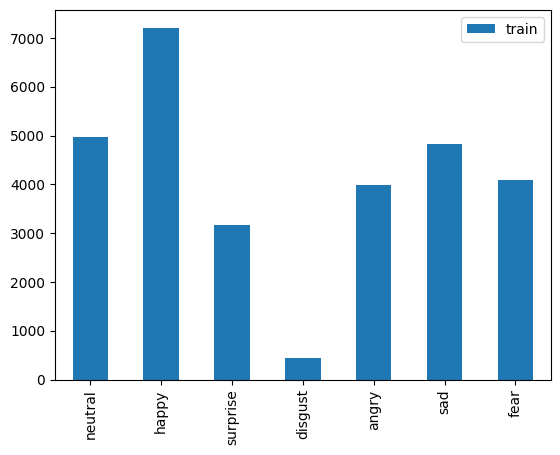

In [8]:
train_count.transpose().plot(kind='bar')

<Axes: >

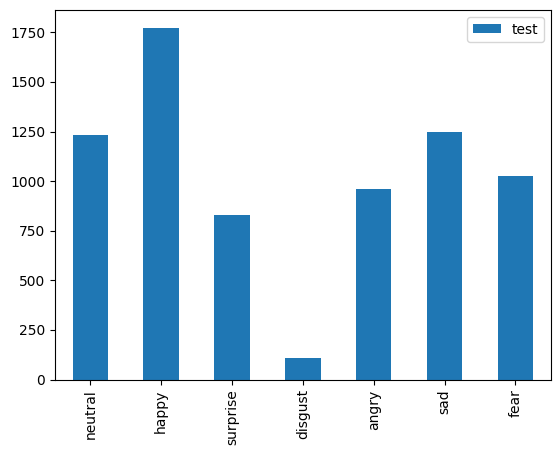

In [9]:
test_count.transpose().plot(kind='bar')

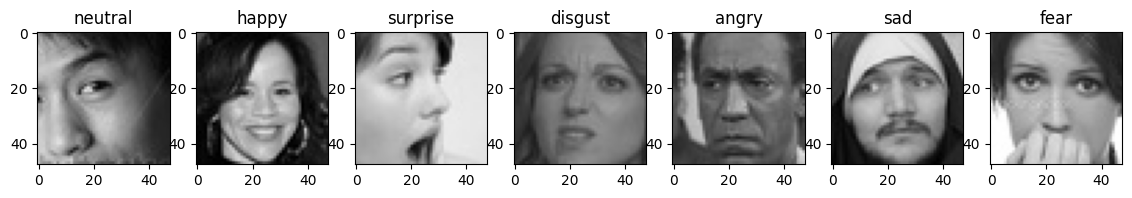

In [10]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('on')
    i += 1
plt.show()

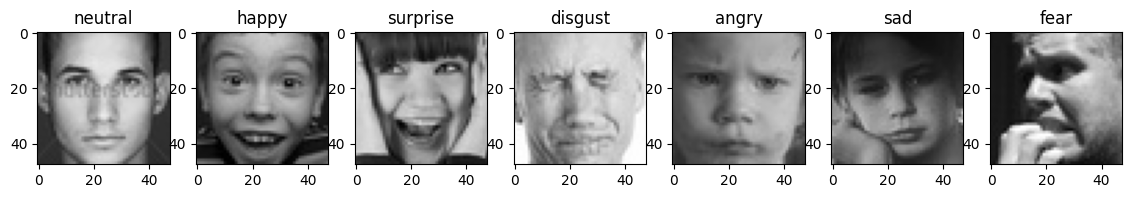

In [11]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('on')
    i += 1
plt.show()

**DATA Augmentation**


---



In [14]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the function to augment all classes to a specified goal value
def augment_all_classes(train_path, goal_value):
    classes = os.listdir(train_path)

    for expression in classes:
        class_path = os.path.join(train_path, expression)

        # Count the current number of images in the class
        current_count = len(os.listdir(class_path))

        if current_count >= goal_value:
            print(f"No augmentation needed for the '{expression}' class.")
            continue

        # Calculate the number of images to be augmented
        to_be_augmented = goal_value - current_count
        print(f"'{expression}' class contains {current_count} images ===> to be augmented: {to_be_augmented}")

        # Load existing images in the class
        batches = ImageDataGenerator().flow_from_directory(directory=train_path,
                                                           target_size=(48, 48),
                                                           batch_size=current_count,
                                                           classes=[expression],
                                                           color_mode='grayscale')
        imgs, labels = next(batches)

        X_train = imgs / 255.
        y_train = labels

        # Generate augmented data and save them in the class folder
        fname_aug = class_path

        # Number of images to be added to_be_augmented OR an integer
        aug_size = int(to_be_augmented * 0.25)

        # Method 1: feature standardization
        datagen_fs = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
        datagen_fs.fit(X_train)
        for X_batch, y_batch in datagen_fs.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                save_prefix='aug_fs_', save_format='png'):
            break

        # Method 2: Random Rotation
        datagen_rot = ImageDataGenerator(rotation_range=10)
        datagen_rot.fit(X_train)
        for X_batch, y_batch in datagen_rot.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                 save_prefix='aug_rot_', save_format='png'):
            break

        # Method 3: Random shifts
        shift = 0.1
        datagen_shifts = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
        datagen_shifts.fit(X_train)
        for X_batch, y_batch in datagen_shifts.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                    save_prefix='aug_shift_', save_format='png'):
            break

        # Method 4: Random flips
        datagen_flips = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
        datagen_flips.fit(X_train)
        for X_batch, y_batch in datagen_flips.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                   save_prefix='aug_flips_', save_format='png'):
            break


# Path to the train part of the dataset
train_dir = 'fer2013/train/'

# Set the goal value for all classes
all_classes_goal_value = 7000

# Call the function to augment all classes
augment_all_classes(train_dir, all_classes_goal_value)

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {total_images}")

TOP_EMOTIONS = ["fear", "surprise", "sad", "happy", "neutral","disgust" ,"angry"]



img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1
i = 0
e = 0
for dir_ in os.listdir('fer2013/test/'):
        label_to_text[e] = dir_
        for f in os.listdir('fer2013/test/' + dir_ + "/"):
            img_arr[i] = cv2.imread('fer2013/test/' + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label


label_to_text

'neutral' class contains 6997 images ===> to be augmented: 3
Found 6997 images belonging to 1 classes.
No augmentation needed for the 'happy' class.
'surprise' class contains 6999 images ===> to be augmented: 1
Found 6999 images belonging to 1 classes.
'disgust' class contains 2180 images ===> to be augmented: 4820
Found 2180 images belonging to 1 classes.
'angry' class contains 6999 images ===> to be augmented: 1
Found 6999 images belonging to 1 classes.
'sad' class contains 6998 images ===> to be augmented: 2
Found 6998 images belonging to 1 classes.
'fear' class contains 6997 images ===> to be augmented: 3
Found 6997 images belonging to 1 classes.
neutral has 6997 number of images
happy has 7215 number of images
surprise has 6999 number of images
disgust has 7000 number of images
angry has 6999 number of images
sad has 6998 number of images
fear has 6997 number of images

total images are 49205
loaded all neutral images to numpy arrays
loaded all happy images to numpy arrays
loaded 

{0: 'neutral',
 1: 'happy',
 2: 'surprise',
 3: 'disgust',
 4: 'angry',
 5: 'sad',
 6: 'fear'}

In [15]:

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)
INPUT_PATH = 'fer2013/train/'

       neutral  happy  surprise  disgust  angry   sad  fear
train     6997   7215      6999     7000   6999  6998  6997
      neutral  happy  surprise  disgust  angry   sad  fear
test     1233   1774       831      111    958  1247  1024


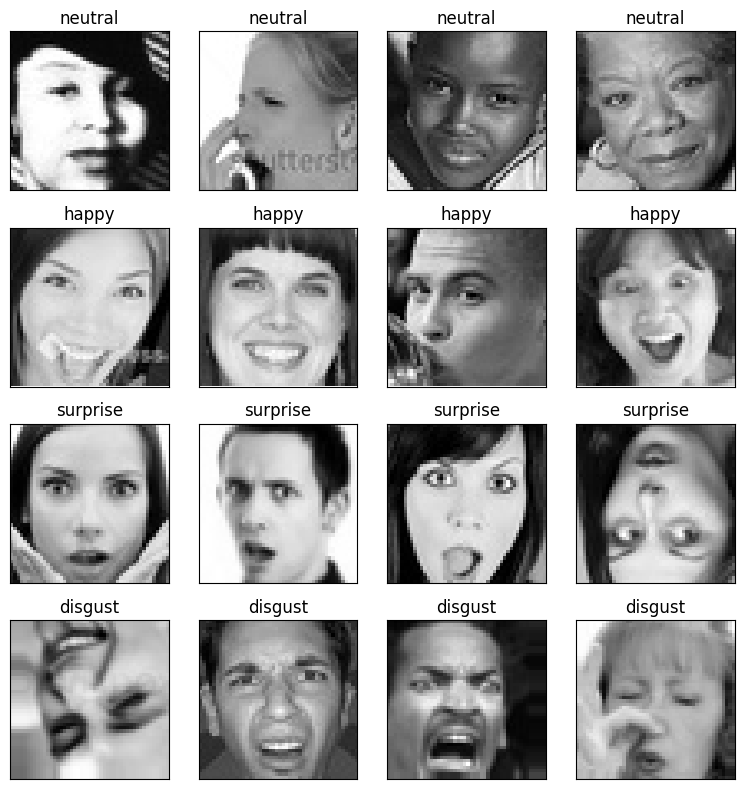

In [16]:
fig = plt.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        if idx <= 16:
            ax = plt.subplot(4, 4, idx)
            ax.imshow(img[:,:,0], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[k])
            plt.tight_layout()


In [17]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
img_label = to_categorical(img_label)
img_label.shape
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
img_arr = img_arr / 255.
del img_arr
del img_label
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17225924/17225924 [==============================] - 1s 0us/step


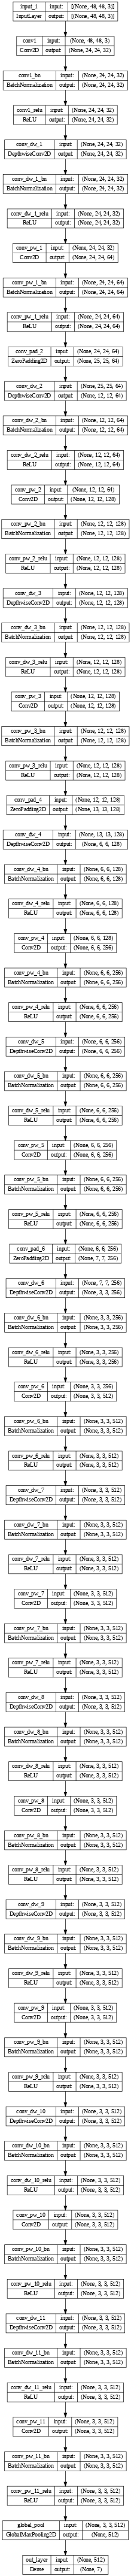

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)



early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]



batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model_yaml = model.to_json()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model_moblenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


154/154 [==============================] - 2s 8ms/step
test accuracy: 69.8232 %


              precision    recall  f1-score   support

           0       0.32      0.28      0.30       123
           1       0.80      0.89      0.84       881
           2       0.77      0.82      0.79       783
           3       0.99      0.86      0.92       711
           4       0.59      0.61      0.60       796
           5       0.55      0.68      0.60       825
           6       0.60      0.40      0.48       802

    accuracy                           0.70      4921
   macro avg       0.66      0.65      0.65      4921
weighted avg       0.70      0.70      0.69      4921



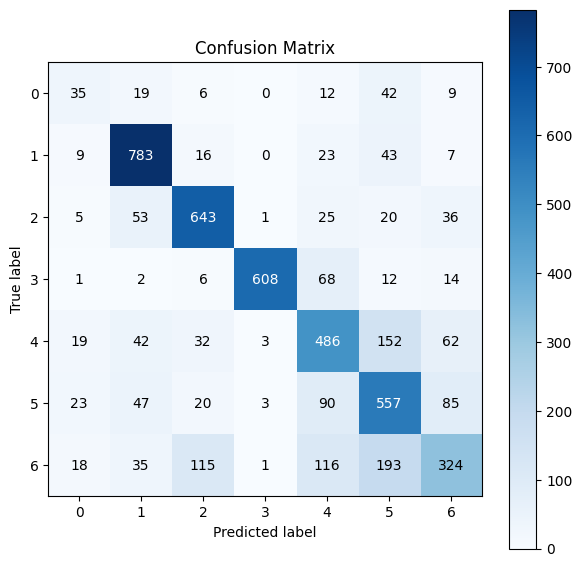

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)
!pip install scikit-plot
import scikitplot
scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
plt.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

154/154 [==============================] - 2s 10ms/step - loss: 0.8112 - accuracy: 0.6982
Test Accuracy: 69.82%
1/1 [==============================] - 1s 562ms/step


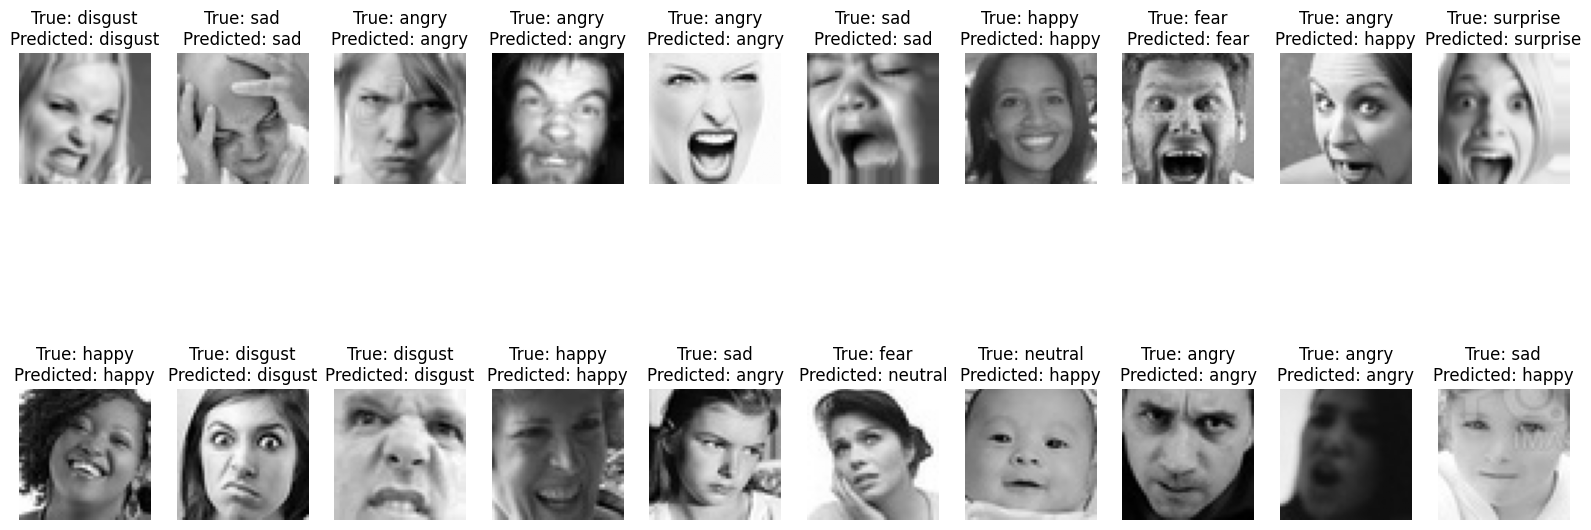

In [ ]:
# Load the saved model
from tensorflow.keras.models import model_from_yaml

with open("model_mobelnet.yaml", "r") as yaml_file:
    loaded_model_yaml = yaml_file.read()

model.load_weights("model_moblenet.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on a few test samples
num_samples = 20  # Change to 20
sample_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Predictions
predictions = model.predict(sample_images)

# Convert predictions to emotion labels
predicted_emotions = [label_to_text[np.argmax(pred)] for pred in predictions]

# True labels
true_emotions = [label_to_text[np.argmax(label)] for label in sample_labels]

# Display the predictions
plt.figure(figsize=(20, 8))  # Adjust the figure size
for i in range(num_samples):
    plt.subplot(2, 10, i + 1)  # Adjust the layout
    plt.imshow(sample_images[i])
    plt.title(f'True: {true_emotions[i]}\nPredicted: {predicted_emotions[i]}')
    plt.axis('off')

plt.show()
